In [54]:
import random
import statistics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from enum import Enum


Load ln data

In [295]:
read_file = pd.read_csv("../Raw_ln.csv")

read_file = read_file.iloc[:, :]

data = read_file.transpose()

X = data.iloc[1:, :-1]
Y = data.iloc[1:, -1]
Y = Y.astype(int)
Stages = np.zeros(13)
print(X.shape)
print(Y.shape)

(1094, 17000)
(1094,)


Load Raw data

In [3]:
read_file = pd.read_csv("./Raw_data.csv")

read_file = read_file.iloc[:, 1:]

data = read_file.transpose()

X = data.iloc[:, :-1]
Y = data.iloc[:, -1]
Y = Y.astype(int)
Stages = np.zeros(13)
print(X.shape)
print(Y.shape)

(1094, 17000)
(1094,)


number of zeros:

In [6]:
print("number of zeros in data(X): ", np.where(X == 0)[0].__len__())
print("located at: ", np.where(X == 0))

number of zeros in data(X):  0
located at:  (array([], dtype=int64), array([], dtype=int64))


replace machine read error(replace 0 with mean):

In [5]:
means = (np.mean(X, axis=0) * X.shape[0]) / (X.shape[0] - np.count_nonzero(X == 0, axis=0))
zero_indices = np.where(X == 0)
X.values[zero_indices] = means[zero_indices[1]]

perform log

In [7]:
# epsi = 10e-10
X = np.log(X)
X.replace([np.inf, -np.inf], 0, inplace=True)

In [18]:
print(np.max(X))

3.0434933369522508


In [259]:
np.transpose(X).to_csv("../Raw_avg_fix.csv")

In [ ]:
print(np.histogram(X.iloc[:, 1500], bins=100)) # edit this to view a histogram

'clip' the edges to cancle the effect of rare samples:

Set threshold by 1% value:

In [37]:
thresholds = np.percentile(X, 1, axis=0) # (TODO) - test precentile output

Set threshhold by 1% order:

In [227]:
# (TODO) - test median output
smallest_indices = np.argsort(X, axis=0)[int(X.shape[0] * 0.01) - 1]

thresholds = X.values[smallest_indices, np.arange(X.shape[1])]

Debug snippet:

In [267]:
print(thresholds)
below_threshold_indices = np.where(X <= thresholds)
print(below_threshold_indices[0].__len__())


[ 7.8478  0.3758 11.0488 ...  9.3899  0.5366  9.0384]
170060


clip action:

In [228]:
below_threshold_indices = np.where(X < thresholds)
print(below_threshold_indices[0].__len__())
X.values[below_threshold_indices] = thresholds[below_threshold_indices[1]]

152946


stage frequency analysis:

In [8]:
for i in range(Y.size):
    Stages[Y.iloc[i]] += 1
print(Stages)

[  7.  90.  86.   6.   6. 358. 257.   2. 156.  27.  65.  20.  14.]


Stage union:

In [9]:
for i in range(Y.size):
    if (Y[i] <= 3): # stages 0, I, IA, IB
        Y[i] = 0
    elif (Y[i] <= 6): # stages II, IIA, IIB
        Y[i] = 1
    else: # (Y[i] <= 10): # stages III, IIIA, IIIB, IIIC
        Y[i] = 2
    # else: # stages IV, X
        # Y[i] = 3 
Stages = np.zeros(3)
for i in range(Y.size):
    Stages[Y.iloc[i]] += 1
print(Stages)

[189. 621. 284.]


Stage deletion:

In [288]:
SumStages = 0
bar = 90
Stage_counter = 13
for i in range(Stages.size):
    if (Stages[i] < bar):
        X = X.drop(index=X.iloc[int(SumStages):int(SumStages) + int(Stages[i]), :].index.tolist(), inplace=False)
        Y = Y.drop(index=Y.iloc[int(SumStages):int(SumStages) + int(Stages[i])].index.tolist(), inplace=False)
        Stage_counter = Stage_counter - 1
    else:
        SumStages += Stages[i]

Stages = np.zeros(Stage_counter)
for i in range(Y.size):
    Stages[Y.iloc[i]] += 1
print(Stages)

[189. 621. 250.   0.   0.   0.   0.   0.   0.   0.   0.   0.]


run TSNE:

[Text(0.5, 1.0, 'TSNE distribution')]

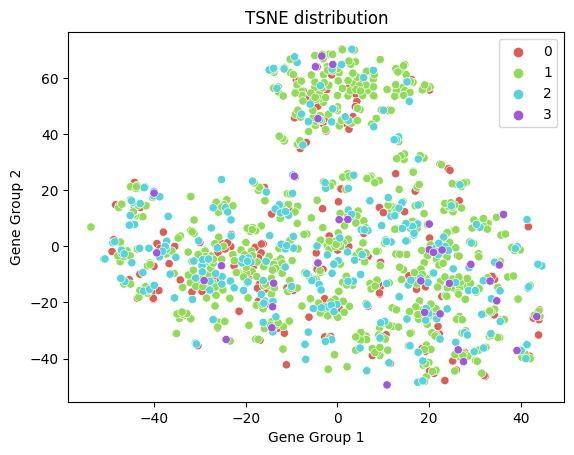

In [268]:
X = TSNE(n_components=2, learning_rate='auto', perplexity=3).fit_transform(X)
df = pd.DataFrame()
df["y"] = Y
df["Gene Group 1"] = X[:,0]
df["Gene Group 2"] = X[:,1]

sns.scatterplot(x="Gene Group 1", y="Gene Group 2", hue=df.y.tolist(),palette=sns.color_palette("hls", 4),data=df).set(title="TSNE distribution")

gene STD clean:

In [275]:
bar = 0.05
print("total genes: ", X.shape[1])
X = X.loc[:,X.std(axis=0) > bar]
print("reduced to ", X.shape[1], "genes with STD > ", bar)

total genes:  17000
reduced to  15115 genes with STD >  0.05


SVD clean:

In [10]:
svd = TruncatedSVD(n_components=1094, random_state=42)
X1 = svd.fit_transform(X)
Sigma = np.diag(svd.singular_values_)
V = svd.components_
print(svd.singular_values_)
# print(np.mean(np.abs(X - X1)))

[8556.60558149  363.02303398  311.0655519  ...   11.14709164   11.05129637
   11.03916558]


In [11]:
X = X1

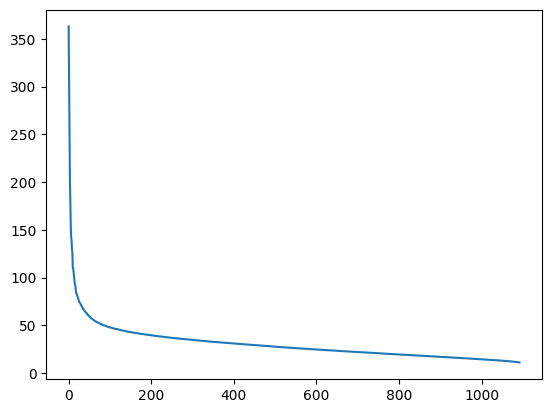

In [287]:
# print(svd.singular_values_[:100])
plt.plot(svd.singular_values_[1:])
# plt.plot([100,svd.singular_values_[100]])

In [22]:
bar = 30
per = 0.5
found = [False, False]
for i in range(svd.singular_values_.size):
    if svd.singular_values_[i] < bar and not found[0]:
        print("trauncate at ", i, "for values > ", bar)
        found[0] = True
    elif i/svd.singular_values_.size > per and not found[1]:
        print(per * 100, "% value: ", svd.singular_values_[i-1])
        found[1] = True
    if found[0] and found[1]:
        break
if not found[0]:
    print("all value's are greater then ", bar)

trauncate at  426 for values >  30
50.0 % value:  26.163952390812746


In [23]:
np.histogram(svd.singular_values_, )

(array([1093,    0,    0,    0,    0,    0,    0,    0,    0,    1],
       dtype=int64),
 array([  11.03916558,  865.59580717, 1720.15244876, 2574.70909035,
        3429.26573194, 4283.82237353, 5138.37901512, 5992.93565672,
        6847.49229831, 7702.0489399 , 8556.60558149]))

Shuffle data:

In [ ]:
X, Y = shuffle(X, Y, random_state=0)

split to train and test groups:

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

normal distribution:

In [51]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

range distribution:

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler().fit(X_train)
X_train = min_max_scaler.transform(X_train)
X_test = min_max_scaler.transform(X_test)

logistical regression:

In [50]:
model = LogisticRegression(random_state=0, max_iter=1000, multi_class="multinomial", n_jobs=-1, C=0.001)

Logistic Regression Cross Validation

In [81]:
model = LogisticRegressionCV(cv=3,Cs=1, random_state=0, max_iter=100, multi_class="multinomial", n_jobs=-1)

In [45]:
# (TODO) - add more models(adaboost, svm, random forest)
model = SVC(random_state=0, max_iter=10000, C=20)

Linear regression:

In [198]:
model = LinearRegression(copy_X=True, n_jobs=-1)

In [69]:
model = AdaBoostClassifier(n_estimators=150,random_state=42)

In [74]:
def adaboost(X_train, Y_train, n_estimators = 50):
    print(Y.shape[0])
    weights = np.zeros((Y_train.shape[0]))
    alpha = {}
    for i in range(Y_train.shape[0]):
        weights[i] = 1 / Y_train.shape[0]
    model = np.zeros((n_estimators, 1), dtype=object)    
    for i in range(n_estimators):
        model[i] = LogisticRegression(random_state=0, max_iter=1000, multi_class="multinomial", n_jobs=-1, C=0.00001)
        model[i].fit(X_train, Y_train, sample_weight = weights)
        score = model[i].score(X_train, Y_train, weights)
        alpha[i] = np.log((1 - (score))/ (score)) / 2
        X_train_pred = model[i].predict(X_train)
        for j in range(Y_train.shape[0]):
            if X_train_pred[j] == Y_train[j]:
                X_train_pred[j] = 1
            else:
                X_train_pred[j] = -1
            # math.exp(alpha[i])
            weights[j] = weights[j] * math.exp( (alpha[i]) * X_train_pred[j])
        weights = weights/ sum(weights)
        
adaboost(X_train,Y_train)
    

1094


IndexError: index 2 is out of bounds for axis 0 with size 2

train the model and predict:

In [51]:
model.fit(X_train, Y_train)
model.score
Y_test_pred = model.predict(X_test)
Y_train_pred = model.predict(X_train)

report for classification:

In [56]:
print("test score: ")
print(metrics.classification_report(y_true=Y_test, y_pred=Y_test_pred))
print("train score: ")
print(metrics.classification_report(y_true=Y_train, y_pred=Y_train_pred))

test score: 
              precision    recall  f1-score   support

           0       1.00      0.05      0.10        38
           1       0.65      0.96      0.77       134
           2       0.56      0.21      0.31        47

    accuracy                           0.64       219
   macro avg       0.73      0.41      0.39       219
weighted avg       0.69      0.64      0.56       219

train score: 
              precision    recall  f1-score   support

           0       0.98      0.32      0.48       151
           1       0.75      1.00      0.85       487
           2       0.96      0.72      0.82       237

    accuracy                           0.80       875
   macro avg       0.89      0.68      0.72       875
weighted avg       0.84      0.80      0.78       875



classify for linear regression and report:

In [201]:
for i in range(Y_test_pred.shape[0]):
    if Y_test_pred[i] % 1 < 0.5:
        Y_test_pred[i] = int(Y_test_pred[i])
    else:
        Y_test_pred[i] = int(Y_test_pred[i] + 1)

for i in range(Y_train_pred.shape[0]):
    if Y_train_pred[i] % 1 < 0.5:
        Y_train_pred[i] = int(Y_train_pred[i])
    else:
        Y_train_pred[i] = int(Y_train_pred[i] + 1)

print(metrics.classification_report(y_true=Y_test, y_pred=Y_test_pred))
print(metrics.classification_report(y_true=Y_train, y_pred=Y_train_pred))

              precision    recall  f1-score   support

           0       0.23      0.08      0.12        38
           1       0.62      0.78      0.69       134
           2       0.35      0.30      0.32        44
           3       0.00      0.00      0.00         3

    accuracy                           0.55       219
   macro avg       0.30      0.29      0.28       219
weighted avg       0.49      0.55      0.51       219

              precision    recall  f1-score   support

           0       0.42      0.10      0.16       151
           1       0.60      0.86      0.71       487
           2       0.50      0.35      0.41       206
           3       1.00      0.03      0.06        31

    accuracy                           0.58       875
   macro avg       0.63      0.34      0.34       875
weighted avg       0.56      0.58      0.52       875



test group Confusion matrix:

<Axes: >

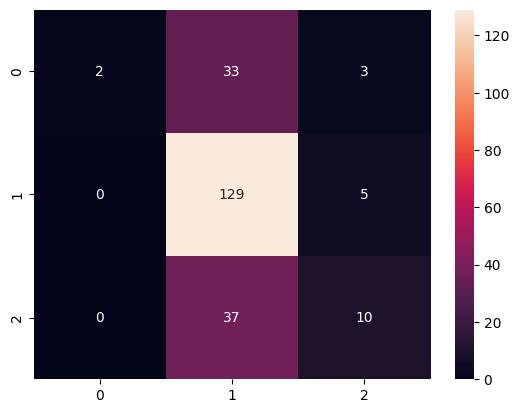

In [53]:
conMat = confusion_matrix(Y_test, Y_test_pred)
sns.heatmap(conMat, annot=True, fmt='g') 

train group confusion matrix

<Axes: >

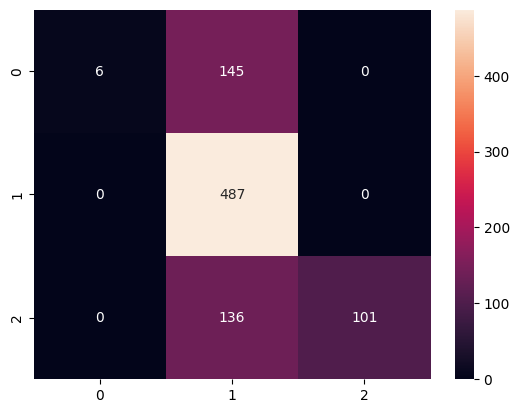

In [48]:
conMat = confusion_matrix(Y_train, Y_train_pred)
sns.heatmap(conMat, annot=True, fmt='g')

manual printing function to print a dict report:

In [35]:
def print_report_dict(report):
    print("\t      precision    recall  f1-score   support\n")
    for i in range(Stages.shape[0]):
        indexStr = " " * (4 - str(i).__len__()) + "%d" % (i)
        supportStr = " " * (7 - str(int(report[str(i)]['support'])).__len__()) + "%d" % (report[str(i)]['support'])
        print("\t%s       %.2f      %.2f      %.2f   %s" % (indexStr, report[str(i)]['precision'], report[str(i)]['recall'], report[str(i)]['f1-score'], supportStr))
    print()
    supportStr = " " * (7 - str(int(report['macro avg']['support'])).__len__()) + "%d" % (report['macro avg']['support'])
    print("    accuracy                           %.2f   %s" % (report['accuracy'], supportStr))
    print("   macro avg       %.2f      %.2f      %.2f   %s" % (report['macro avg']['precision'], report['macro avg']['recall'], report['macro avg']['f1-score'], supportStr))
    print("weigthed avg       %.2f      %.2f      %.2f   %s\n" % (report['weighted avg']['precision'], report['weighted avg']['recall'], report['weighted avg']['f1-score'], supportStr))


stability check:

In [36]:
n = 5
test_reports = np.zeros((n), dtype=object)
train_reports = np.zeros((n), dtype=object)

test_avg_report = {'accuracy': 0,
        'macro avg': {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0}, 
        'weighted avg': {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0}}
train_avg_report = {'accuracy': 0,
        'macro avg': {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0}, 
        'weighted avg': {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0}}
test_std_report = {'accuracy': 0,
        'macro avg': {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0}, 
        'weighted avg': {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0}}
train_std_report = {'accuracy': 0,
        'macro avg': {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0}, 
        'weighted avg': {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0}}
for i in range(Stages.shape[0]):
    test_avg_report.update({str(i): {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0}})
    test_std_report.update({str(i): {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0}})
    train_avg_report.update({str(i): {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0}})
    train_std_report.update({str(i): {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0}})

for i in range(n):
    # rand = random.randint(0, 100)
    
    # shuffle and split
    X, Y = shuffle(X, Y)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
    
    # scale:
    # scaler = preprocessing.StandardScaler().fit(X_train)
    # X_train = scaler.transform(X_train)
    # X_test = scaler.transform(X_test)
    
    # fit and predict
    model.fit(X_train, Y_train)
    Y_test_pred = model.predict(X_test)
    Y_train_pred = model.predict(X_train)
    
    # score
    test_reports[i] = metrics.classification_report(y_true=Y_test, y_pred=Y_test_pred, output_dict=True)
    train_reports[i] = metrics.classification_report(y_true=Y_train, y_pred=Y_train_pred, output_dict=True)
    
    # calc avg
    for label, dictData in test_reports[i].items():
        if label != 'accuracy':
            for k in set(dictData):
                test_avg_report[label][k] += dictData.get(k, 0) / n
        else:
            test_avg_report[label] += dictData / n
    for label, dictData in train_reports[i].items():
        if label != 'accuracy':
            for k in set(dictData):
                train_avg_report[label][k] += dictData.get(k, 0) / n
        else:
            train_avg_report[label] += dictData / n
  
# calc std report
for i in range(n):    
    for label, dictData in test_reports[i].items():
        if label != 'accuracy':
            for k in set(dictData):
                test_std_report[label][k] += ((dictData.get(k, 0) - test_avg_report[label][k]) ** 2) / n
        else:
            test_std_report[label] += ((dictData - test_avg_report['accuracy']) ** 2) / n
    for label, dictData in train_reports[i].items():
        if label != 'accuracy':
            for k in set(dictData):
                train_std_report[label][k] += ((dictData.get(k, 0) - train_avg_report[label][k]) ** 2) / n
        else:
            train_std_report[label] += ((dictData - train_avg_report['accuracy']) ** 2) / n
            

print("test average report: ")
print_report_dict(test_avg_report)
print("test std: ")
print_report_dict(test_std_report)

print("train average report: ")
print_report_dict(train_avg_report)
print("train std: ")
print_report_dict(test_std_report)

c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarn

test average report: 
	      precision    recall  f1-score   support

	   0       0.19      0.17      0.18        35
	   1       0.59      0.73      0.65       126
	   2       0.20      0.12      0.15        48
	   3       0.00      0.00      0.00         8

    accuracy                           0.48       219
   macro avg       0.24      0.26      0.24       219
weigthed avg       0.41      0.48      0.44       219

test std: 
	      precision    recall  f1-score   support

	   0       0.01      0.01      0.01         5
	   1       0.00      0.00      0.00        17
	   2       0.00      0.00      0.00        10
	   3       0.00      0.00      0.00        11

    accuracy                           0.00         0
   macro avg       0.00      0.00      0.00         0
weigthed avg       0.00      0.00      0.00         0

train average report: 
	      precision    recall  f1-score   support

	   0       0.30      0.22      0.25       153
	   1       0.62      0.76      0.68       494
	 

c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [413]:
print("test average report: ")
print_report_dict(test_avg_report)

print("train average report: ")
print_report_dict(train_avg_report)

test average report: 
	      precision    recall  f1-score   support

	   0       0.32      0.39      0.35        41
	   1       0.64      0.56      0.60       122
	   2       0.37      0.47      0.41        47
	   3       0.00      0.00      0.00         7

    accuracy                           0.49       219
   macro avg       0.33      0.35      0.34       219
weigthed avg       0.50      0.49      0.49       219

train average report: 
	      precision    recall  f1-score   support

	   0       0.70      0.99      0.82       147
	   1       0.98      0.77      0.86       498
	   2       0.77      0.94      0.84       202
	   3       1.00      1.00      1.00        26

    accuracy                           0.85       875
   macro avg       0.86      0.92      0.88       875
weigthed avg       0.88      0.85      0.86       875

